# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080


3.5327065413082614 -0.3812184238940165
3.5367073414682935 -0.38491404279509217
3.5407081416283255 -0.3886035006155121
3.5447089417883575 -0.3922867383004102
3.5487097419483895 -0.3959636968944826
3.5527105421084215 -0.39963431754293044
3.5567113422684535 -0.40329854149240285
3.5607121424284855 -0.4069563100919367
3.5647129425885176 -0.41060756479389593
3.5687137427485496 -0.41425224715490805
3.5727145429085816 -0.4178902988368001
3.5767153430686136 -0.4215216616075325
3.5807161432286456 -0.4251462773421307
3.5847169433886776 -0.4287640880236157
3.5887177435487096 -0.43237503574393304
3.5927185437087417 -0.43597906270487924
3.5967193438687737 -0.4395761112190272
3.6007201440288057 -0.4431661237106494
3.6047209441888377 -0.44674904271663973
3.6087217443488697 -0.45032481088743304
3.6127225445089017 -0.4538933709879231
3.6167233446689337 -0.45745466589837885
3.6207241448289658 -0.4610086386153587
3.6247249449889978 -0.46455523225262274
3.62872574514903 -0.4680943900420435
3.6327265453090


6.741348269653931 0.4423012767312956
6.745349069813963 0.44588591111222625
6.749349869973995 0.4494634084735728
6.753350670134027 0.45303371155255096
6.757351470294059 0.4565967632015309
6.761352270454091 0.460152506388952
6.765353070614123 0.46370088420023553
6.769353870774155 0.4672418398386958
6.773354670934187 0.4707753166264494
6.777355471094219 0.4743012580053221
6.781356271254251 0.47781960753775415
6.785357071414283 0.4813303089077042
6.789357871574315 0.4848333059215499
6.793358671734347 0.48832854250898794
6.797359471894379 0.49181596272393135
6.801360272054411 0.49529551074540495
6.805361072214443 0.4987671308784389
6.809361872374475 0.5022307675549601
6.813362672534507 0.5056863653346818
6.817363472694539 0.5091338689059909
6.821364272854571 0.5125732230868331
6.825365073014603 0.5160043728255965
6.829365873174635 0.5194272632019926
6.833366673334667 0.5228418394279355
6.837367473494699 0.5262480468484184
6.841368273654731 0.5296458309423893
6.845369073814763 0.53303513732

9.601920384076815 -0.17621743749200708
9.605921184236847 -0.180154209386514
9.609921984396879 -0.18408809766418416
9.61392278455691 -0.1880190393577047
9.617923584716943 -0.19194697154692686
9.621924384876975 -0.19587183135987313
9.625925185037007 -0.1997935559737437
9.629925985197039 -0.2037120826159219
9.63392678535707 -0.20762734856497903
9.637927585517103 -0.21153929115167827
9.641928385677135 -0.21544784775997777
9.645929185837167 -0.21935295582803305
9.649929985997199 -0.22325455284919815
9.65393078615723 -0.22715257637302633
9.657931586317263 -0.2310469640062696
9.661932386477295 -0.23493765341387743
9.665933186637327 -0.23882458231999446
9.669933986797359 -0.24270768850895735
9.67393478695739 -0.2465869098262907
9.677935587117423 -0.2504621841797018
9.681936387277455 -0.2543334495400744
9.685937187437487 -0.25820064394246206
9.689937987597519 -0.26206370548707925
9.693938787757551 -0.2659225723402928
9.697939587917583 -0.26977718273561135
9.701940388077615 -0.2736274749746739
9

12.418483696739347 -0.1473484456563956
12.42248449689938 -0.1433901469481171
12.426485297059411 -0.13942955308257654
12.430486097219443 -0.1354667274545466
12.434486897379475 -0.13150173349452246
12.438487697539507 -0.12753463466770634
12.44248849769954 -0.1235654944729919
12.446489297859571 -0.11959437644194756
12.450490098019603 -0.11562134413779987
12.454490898179635 -0.11164646115441587
12.458491698339667 -0.10766979111528532
12.4624924984997 -0.10369139767250228
12.466493298659731 -0.09971134450574624
12.470494098819763 -0.0957296953212629
12.474494898979795 -0.09174651385084437
12.478495699139827 -0.08776186385080917
12.48249649929986 -0.08377580910098163
12.486497299459892 -0.07978841340367104
12.490498099619924 -0.07579974058265045
12.494498899779956 -0.07180985448213495
12.498499699939988 -0.06781881896575995
12.50250050010002 -0.06382669791555876
12.506501300260052 -0.05983355523094019
12.510502100420084 -0.05583945482766573
12.514502900580116 -0.051844460636826475
12.5185037

-0.14271798075619704
15.855171034206842 -0.1466766735421165
15.859171834366874 -0.1506330185653785
15.863172634526906 -0.15458695249921892
15.867173434686938 -0.15853841205546645
15.87117423484697 -0.16248733398555565
15.875175035007002 -0.16643365508153926
15.879175835167034 -0.17037731217709995
15.883176635327066 -0.1743182421485614
15.887177435487098 -0.17825638191589874
15.89117823564713 -0.18219166844374807
15.895179035807162 -0.1861240387424156
15.899179835967194 -0.19005342986888574
15.903180636127226 -0.19397977892782875
15.907181436287258 -0.19790302307260735
15.91118223644729 -0.20182309950628266
15.915183036607322 -0.20573994548261945
15.919183836767354 -0.20965349830709035
15.923184636927386 -0.2135636953378795
15.927185437087418 -0.21747047398688513
15.93118623724745 -0.22137377172072134
15.93518703740748 -0.2252735260617174
15.939187837567513 -0.2291696745889247
15.943188637727545 -0.23306215493910543
15.947189437887577 -0.23695090480773767
15.951190238047609 -0.240835861

0.2900440291063333
19.14782956591318 0.29387051658834823
19.151830366073213 0.29769230026703636
19.155831166233245 0.3015093189694736
19.159831966393277 0.30532151159900595
19.16383276655331 0.3091288171362274
19.16783356671334 0.3129311746399566
19.171834366873373 0.3167285232482123
19.175835167033405 0.32052080217918744
19.179835967193437 0.3243079507322223
19.18383676735347 0.32808990828877577
19.1878375675135 0.331866614313396
19.191838367673533 0.335638008354689
19.195839167833565 0.33940403004628644
19.199839967993597 0.34316461910781193
19.20384076815363 0.3469197153458458
19.20784156831366 0.3506692586548886
19.211842368473693 0.35441318901832314
19.215843168633725 0.35815144650937514
19.219843968793757 0.3618839712920726
19.22384476895379 0.3656107036222033
19.22784556911382 0.36933158384827136
19.231846369273853 0.37304655241245177
19.235847169433885 0.37675554985154386
19.239847969593917 0.38045851679792314
19.24384876975395 0.3841553939804914
19.24784956991398 0.38784612222

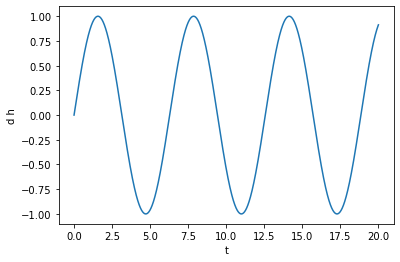

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

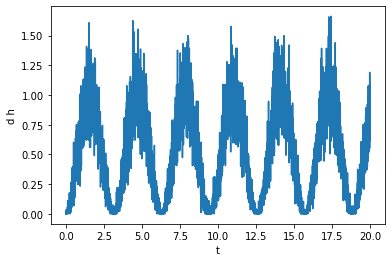

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

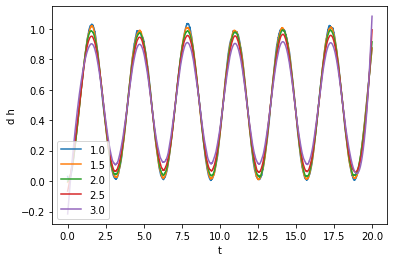

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

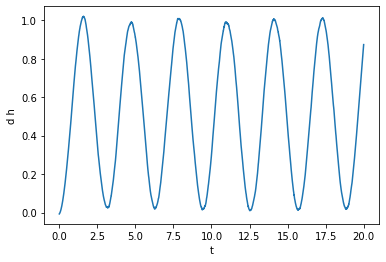

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.2139


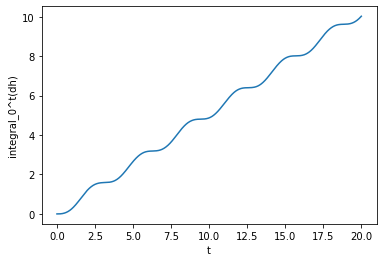

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

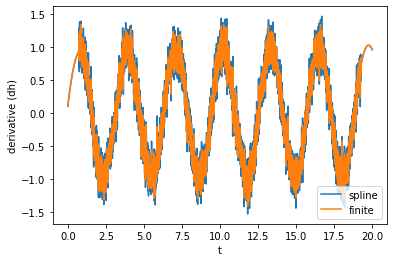

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

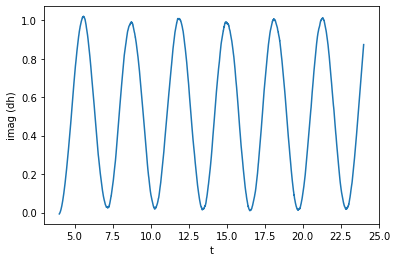

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

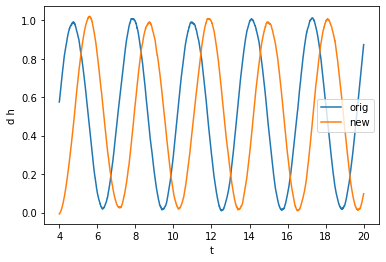

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

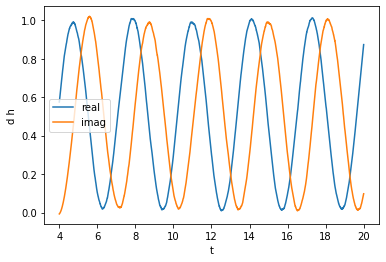

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

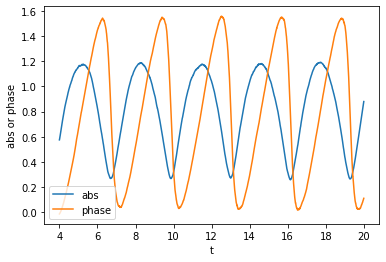

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

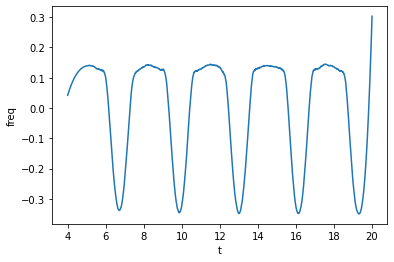

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

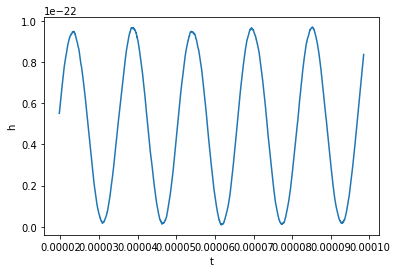

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

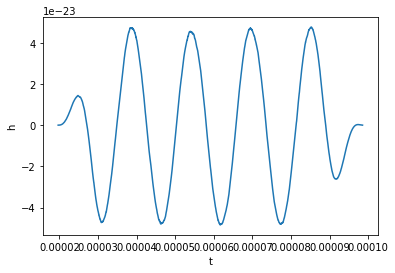

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

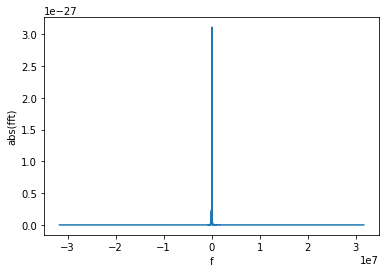

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

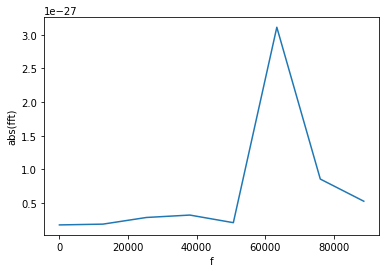

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64228.69


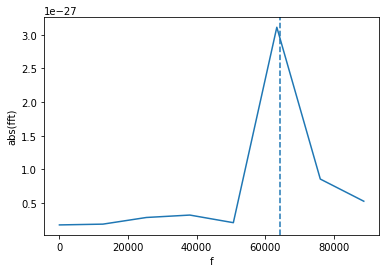

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.111e-27
Maximum with mask 8.568e-28
Length with mask 8
Length after having removed the masked points 7
